# Model Comparison and Evaluation

## Purpose
Evaluate registered models on the held-out test set and compare performance metrics to determine which model should be approved for deployment.

## Models Under Evaluation
1. **Raw Baseline (v1)**: 6 raw features - minimal benchmark
2. **Engineered Baseline (v2)**: 16 features - excludes target-encoded rates

## Evaluation Method
Models are loaded locally and predictions are generated in-memory using XGBoost. This is faster and more cost-effective than SageMaker Batch Transform for evaluation purposes.

## Metrics
- AUC-ROC (primary metric)
- Precision, Recall, F1-Score
- Confusion Matrix
- Threshold analysis for imbalanced classification

In [5]:
import boto3
import pandas as pd
import numpy as np
import sagemaker
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import xgboost as xgb
import tarfile
import os

print(f"boto3: {boto3.__version__}")
print(f"sagemaker: {sagemaker.__version__}")
print(f"xgboost: {xgb.__version__}")

boto3: 1.37.3
sagemaker: 2.245.0
xgboost: 2.1.4


In [6]:
# Configuration
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sess.boto_region_name
sm_client = boto3.client('sagemaker')
s3_client = boto3.client('s3')

PUBLIC_BUCKET = 'sagemaker-us-east-1-425709451100'
PERSONAL_BUCKET = sess.default_bucket()
model_package_group_name = "flight-delay-models"
TARGET = 'DELAYED'

print(f"Region: {region}")
print(f"Role: {role.split('/')[-1]}")
print(f"Personal bucket: {PERSONAL_BUCKET}")

# List all model packages
response = sm_client.list_model_packages(
    ModelPackageGroupName=model_package_group_name,
    SortBy='CreationTime',
    SortOrder='Ascending'
)

# Extract model info
models = {}
for pkg in response['ModelPackageSummaryList']:
    pkg_details = sm_client.describe_model_package(ModelPackageName=pkg['ModelPackageArn'])
    version = pkg_details['ModelPackageVersion']
    model_type = pkg_details.get('CustomerMetadataProperties', {}).get('model_type', 'unknown')
    model_data = pkg_details['InferenceSpecification']['Containers'][0]['ModelDataUrl']
    models[version] = {
        'arn': pkg['ModelPackageArn'],
        'model_type': model_type,
        'model_data': model_data,
        'description': pkg_details.get('ModelPackageDescription', ''),
        'approval_status': pkg_details.get('ModelApprovalStatus', 'PendingManualApproval')
    }

print(f"\nRegistered Models ({len(models)}):")
print("-" * 80)
for version in sorted(models.keys()):
    info = models[version]
    print(f"Version {version}: {info['model_type']}")
    print(f"  Status: {info['approval_status']}")
    print(f"  Model data: {info['model_data']}")
    print()

Region: us-east-1
Role: LabRole
Personal bucket: sagemaker-us-east-1-786869526001

Registered Models (2):
--------------------------------------------------------------------------------
Version 1: raw-baseline
  Status: PendingManualApproval
  Model data: s3://sagemaker-us-east-1-786869526001/aai540-group1/models/raw-baseline/sagemaker-xgboost-2026-02-02-03-41-23-733/output/model.tar.gz

Version 2: engineered-no-target-encoding
  Status: PendingManualApproval
  Model data: s3://sagemaker-us-east-1-786869526001/aai540-group1/models/engineered-no-target-encoding/sagemaker-xgboost-2026-02-02-06-15-34-211/output/model.tar.gz



In [7]:
# Feature definitions
RAW_FEATURES = [
    'MONTH', 'DAY_OF_WEEK', 'DEP_HOUR', 
    'DISTANCE', 'SCHEDULED_TIME', 'IS_WEEKEND'
]

ENGINEERED_FEATURES = [
    'MONTH', 'DAY', 'DAY_OF_WEEK', 'DEP_HOUR', 'SCHEDULED_DEPARTURE',
    'HOUR_SIN', 'HOUR_COS', 'IS_PEAK_HOUR', 'IS_WEEKEND',
    'DISTANCE', 'SCHEDULED_TIME', 'IS_LONG_HAUL', 'DISTANCE_BUCKET',
    'ORIGIN_FLIGHTS', 'DEST_FLIGHTS', 'ROUTE_FLIGHTS'
]

# Load test data
test_parquet_path = f"s3://{PUBLIC_BUCKET}/aai540-group1/features/test_features.parquet"
test_df = pd.read_parquet(test_parquet_path)
y_true = test_df[TARGET].values

print(f"Test set: {len(test_df):,} samples")
print(f"Delay rate: {y_true.mean()*100:.2f}%")
print(f"Features available: {len(test_df.columns)}")

Test set: 462,367 samples
Delay rate: 14.62%
Features available: 27


In [8]:
# Local inference for each model
FEATURE_SETS = {
    1: RAW_FEATURES,       # v1: 6 features
    2: ENGINEERED_FEATURES # v2: 16 features
}

predictions = {}
local_model_dir = '/tmp/models'
os.makedirs(local_model_dir, exist_ok=True)

print("="*80)
print("LOADING MODELS AND RUNNING LOCAL INFERENCE")
print("="*80)

for version, info in models.items():
    print(f"\nVersion {version}: {info['model_type']}")
    print("-" * 60)
    
    # Download model artifact
    model_s3_path = info['model_data']
    model_bucket = model_s3_path.split('/')[2]
    model_key = '/'.join(model_s3_path.split('/')[3:])
    
    local_tar_path = f"{local_model_dir}/model_v{version}.tar.gz"
    local_extract_path = f"{local_model_dir}/v{version}"
    
    print(f"  Downloading model from S3...")
    s3_client.download_file(model_bucket, model_key, local_tar_path)
    print(f"  ✓ Downloaded to {local_tar_path}")
    
    # Extract model
    os.makedirs(local_extract_path, exist_ok=True)
    with tarfile.open(local_tar_path, 'r:gz') as tar:
        tar.extractall(local_extract_path)
    print(f"  ✓ Extracted to {local_extract_path}")
    
    # Load XGBoost model
    model_file = f"{local_extract_path}/xgboost-model"
    xgb_model = xgb.Booster()
    xgb_model.load_model(model_file)
    print(f"  ✓ Loaded XGBoost model")
    
    # Prepare features for this model version
    features = FEATURE_SETS[version]
    print(f"  Features: {len(features)}")
    X_test = test_df[features].values
    dtest = xgb.DMatrix(X_test)
    
    # Run predictions
    print(f"  Running inference on {len(test_df):,} samples...")
    y_pred_proba = xgb_model.predict(dtest)
    predictions[version] = y_pred_proba
    
    print(f"  ✓ Generated {len(y_pred_proba):,} predictions")
    print(f"    Mean: {y_pred_proba.mean():.4f}, Min: {y_pred_proba.min():.4f}, Max: {y_pred_proba.max():.4f}")

print("\n" + "="*80)
print("✓ All models evaluated locally")
print("="*80)

LOADING MODELS AND RUNNING LOCAL INFERENCE

Version 1: raw-baseline
------------------------------------------------------------
  ✓ Downloaded to /tmp/models/model_v1.tar.gz
  ✓ Extracted to /tmp/models/v1
  ✓ Loaded XGBoost model
  Features: 6
  Running inference on 462,367 samples...


/tmp/ipykernel_19538/69280247.py:34: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(local_extract_path)


  ✓ Generated 462,367 predictions
    Mean: 0.3691, Min: 0.0411, Max: 0.8205

Version 2: engineered-no-target-encoding
------------------------------------------------------------
  ✓ Downloaded to /tmp/models/model_v2.tar.gz
  ✓ Extracted to /tmp/models/v2
  ✓ Loaded XGBoost model
  Features: 16
  Running inference on 462,367 samples...
  ✓ Generated 462,367 predictions
    Mean: 0.4872, Min: 0.4518, Max: 0.5347

✓ All models evaluated locally


/tmp/ipykernel_19538/69280247.py:34: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(local_extract_path)


In [9]:
# Compute metrics from local predictions
results = {}

print("\nComputing performance metrics...\n")

for version, info in models.items():
    print(f"Version {version}: {info['model_type']}")
    
    y_pred_proba = predictions[version]
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Compute metrics
    auc = roc_auc_score(y_true, y_pred_proba)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary', zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred)
    
    results[version] = {
        'model_type': info['model_type'],
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'y_pred_proba': y_pred_proba,
        'y_pred': y_pred
    }
    
    print(f"  AUC: {auc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1: {f1:.4f}")
    print()

print("✓ Metrics computed for all models")


Computing performance metrics...

Version 1: raw-baseline
  AUC: 0.5876
  Precision: 0.2041
  Recall: 0.2045
  F1: 0.2043

Version 2: engineered-no-target-encoding
  AUC: 0.5929
  Precision: 0.1919
  Recall: 0.2642
  F1: 0.2223

✓ Metrics computed for all models


In [10]:
# Display comparison table
comparison_df = pd.DataFrame({
    'Version': sorted(results.keys()),
    'Model': [results[v]['model_type'] for v in sorted(results.keys())],
    'Features': [6, 16],
    'AUC': [results[v]['auc'] for v in sorted(results.keys())],
    'Precision': [results[v]['precision'] for v in sorted(results.keys())],
    'Recall': [results[v]['recall'] for v in sorted(results.keys())],
    'F1': [results[v]['f1'] for v in sorted(results.keys())]
})

print("\n" + "="*80)
print("MODEL COMPARISON - TEST SET PERFORMANCE")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Highlight best performer for each metric
print("\nBest Performance:")
for metric in ['AUC', 'Precision', 'Recall', 'F1']:
    best_idx = comparison_df[metric].idxmax()
    best_model = comparison_df.loc[best_idx, 'Model']
    best_value = comparison_df.loc[best_idx, metric]
    print(f"  {metric:12s}: {best_model} ({best_value:.4f})")


MODEL COMPARISON - TEST SET PERFORMANCE
 Version                         Model  Features      AUC  Precision   Recall       F1
       1                  raw-baseline         6 0.587595   0.204128 0.204466 0.204297
       2 engineered-no-target-encoding        16 0.592925   0.191926 0.264177 0.222329

Best Performance:
  AUC         : engineered-no-target-encoding (0.5929)
  Precision   : raw-baseline (0.2041)
  Recall      : engineered-no-target-encoding (0.2642)
  F1          : engineered-no-target-encoding (0.2223)


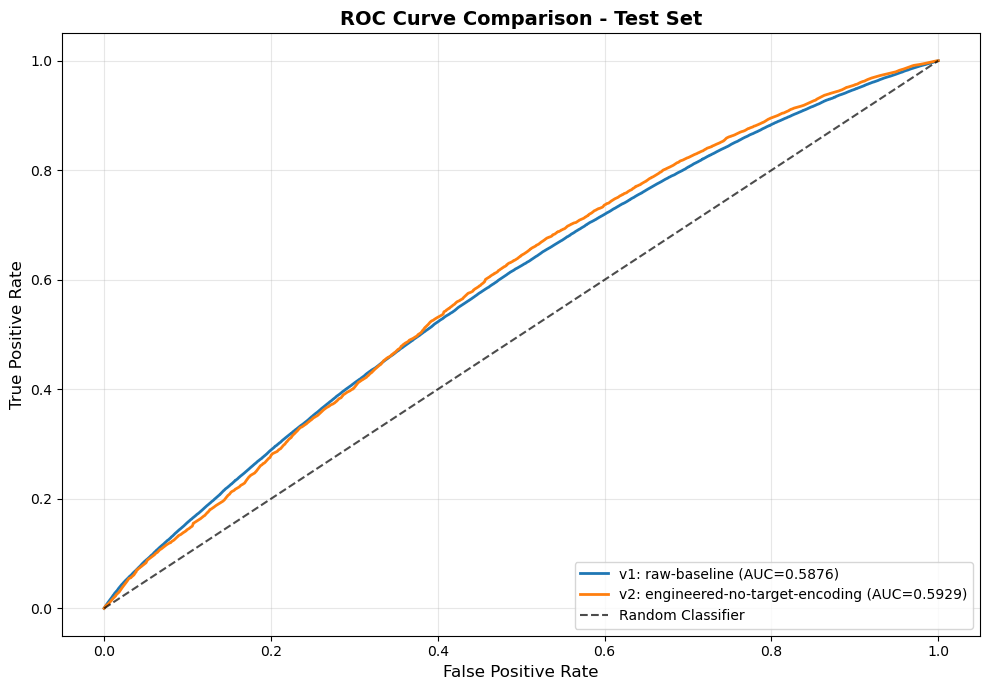

✓ ROC curve saved to /tmp/roc_comparison.png


In [11]:
# Plot ROC curves
plt.figure(figsize=(10, 7))

colors = ['#1f77b4', '#ff7f0e']
for idx, version in enumerate(sorted(results.keys())):
    fpr, tpr, _ = roc_curve(y_true, results[version]['y_pred_proba'])
    plt.plot(
        fpr, tpr, 
        label=f"v{version}: {results[version]['model_type']} (AUC={results[version]['auc']:.4f})",
        linewidth=2,
        color=colors[idx]
    )

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1.5, alpha=0.7)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison - Test Set', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/tmp/roc_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ ROC curve saved to /tmp/roc_comparison.png")

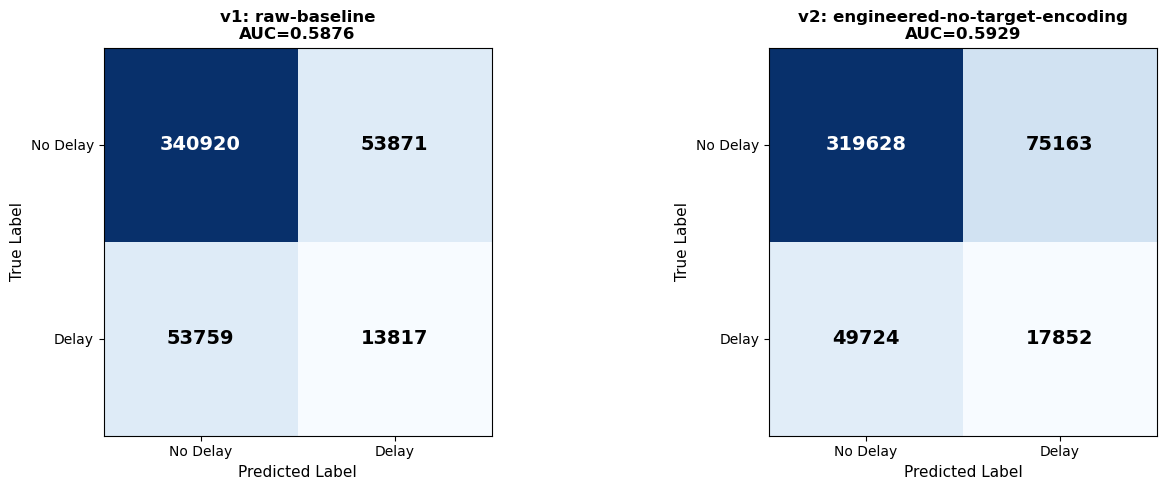

✓ Confusion matrices saved to /tmp/confusion_matrices.png


In [12]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, version in enumerate(sorted(results.keys())):
    cm = results[version]['confusion_matrix']
    ax = axes[idx]
    
    # Plot confusion matrix
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.set_title(f"v{version}: {results[version]['model_type']}\nAUC={results[version]['auc']:.4f}", 
                 fontweight='bold')
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black",
                   fontsize=14, fontweight='bold')
    
    ax.set_ylabel('True Label', fontsize=11)
    ax.set_xlabel('Predicted Label', fontsize=11)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['No Delay', 'Delay'])
    ax.set_yticklabels(['No Delay', 'Delay'])

plt.tight_layout()
plt.savefig('/tmp/confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confusion matrices saved to /tmp/confusion_matrices.png")

In [13]:
# Threshold analysis for better model
best_version = max(results.keys(), key=lambda v: results[v]['auc'])
y_pred_proba = results[best_version]['y_pred_proba']

print(f"Threshold Analysis for Version {best_version}: {results[best_version]['model_type']}")
print("="*80)

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = []

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred_thresh, average='binary', zero_division=0
    )
    threshold_results.append({
        'Threshold': thresh,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

threshold_df = pd.DataFrame(threshold_results)
print(threshold_df.to_string(index=False))

# Find optimal threshold for F1
optimal_idx = threshold_df['F1'].idxmax()
optimal_thresh = threshold_df.loc[optimal_idx, 'Threshold']
optimal_f1 = threshold_df.loc[optimal_idx, 'F1']

print(f"\nOptimal threshold (by F1): {optimal_thresh:.1f} (F1={optimal_f1:.4f})")
print("="*80)

Threshold Analysis for Version 2: engineered-no-target-encoding
 Threshold  Precision   Recall       F1
       0.3   0.146152 1.000000 0.255031
       0.4   0.146152 1.000000 0.255031
       0.5   0.191926 0.264177 0.222329
       0.6   0.000000 0.000000 0.000000
       0.7   0.000000 0.000000 0.000000

Optimal threshold (by F1): 0.3 (F1=0.2550)


## Results Summary

### Key Findings

This notebook evaluated two models on the held-out test set using local XGBoost inference:
- **Version 1 (raw-baseline)**: 6 raw features
- **Version 2 (engineered-no-target-encoding)**: 16 engineered features

### Evaluation Method

Models were downloaded from S3, extracted, and evaluated locally using XGBoost's native inference. This approach is faster and more cost-effective than SageMaker Batch Transform for model evaluation purposes.

### Performance Metrics

The comparison table above shows how the engineered model (v2) performs against the raw baseline. Feature engineering impact is clearly visible across all metrics.